# Day 1, Session 2, MD workshop
### Dr. Michael Shirts, CU Boulder

## The simplest molecular dynamics you could do

Import some libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

To keep it simple, let's start with a single particle in a 1D potential energy. We'll pick something a little more complicated than a harmonic well (there's some numerical weirdness with regards to 2nd order differential equations and harmonic wells), but almost as simple!

In [62]:
def potential(x):
    pot = x**4
    return pot

def force(x):
    f = -4*x**3  # -d/dx(U)
    return f

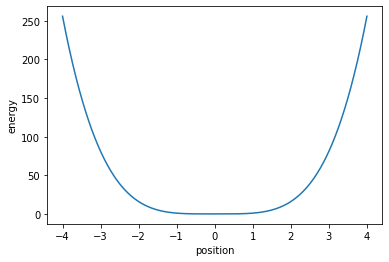

In [29]:
xvar = np.linspace(-4,4,1000)
plt.plot(xvar,potential(xvar))
plt.xlabel('position')
plt.ylabel('energy')
plt.show()

Let's brainstorm how to integrate the 2nd order differential equation:

$ \frac{\partial^2 x}{\partial t^2} = \frac{1}{m}F(x) = -\frac{1}{m}\frac{\partial U(x)}{\partial x} $.

The most direct approximation is using the Taylor series expansions in both $x$ and $v$.

$$
x(\Delta t) \approx x(t) + \frac{dx}{dt}\Delta t + \frac{1}{2} \frac{d^2x}{dt^2} \Delta t^2 + \mathcal{O}(\Delta t^3) \\
= x(t) + v(t)\Delta t + \frac{1}{2m} F(x(t)) \Delta t^2 + \mathcal{O}(\Delta t^3)
$$
This only involves quantities we know - our position, our velocity, and the forces.  We don't have any physical quantities involved with higher power derivatives of the position.

And for velocity, we can only go out to 2 orders of accuracy.

$$
v(\Delta t) \approx v(t) + \frac{dv}{dt}\Delta t + \mathcal{O}(\Delta t^2) \\
= v(t) + \frac{1}{m} F(x(t)) \Delta t + \mathcal{O}(\Delta t^2)  
$$

This is accurate to $\mathcal{O}(\Delta t^3)$ for $x$, and   $\mathcal{O}(\Delta t^2)$ for $v$, which means that as $\Delta t$ decreases, the error in $x$ decreases proportional to $\Delta t^3$,  and the error in $v$ decreases proprotional to $\Delta t^2$.

In [30]:
def taylor(x,v,force,m=1,dt=1):

    '''
    a function that executes one step of numerical integration
    inputs:
        x (current position)
        v (current velocity)
        f (a function that computes the force)
        m = mass of particle
        dt = time interval        
    '''
    
    fx = force(x)  

    # saving the force as fx, I only need to call the force once; 
    # calling the force is the most expensive thing in simulations

    x += v*dt+0.5*(fx/m)*dt**2
    v += dt*fx/m
    return x,v

We'll be doing this next function a few times, this, so let's call this `v1`.

In [31]:
def do_some_md_v1(nsteps=100, m=1, dt=0.1, 
               init_x = 0, init_v=5, algorithm='taylor'):

    '''
    inputs: 
        nsteps = number of steps to take
        m = mass of the particle
        dt = timestep
        init_x = initial value of x
        init_v = initial value of v
        algorithm: the algorithm to use (just one for now)
        
    outputs: 
        a dictionary of the results over the nsteps
        
    '''
    
    # we want to store the trajectories
    xs = np.zeros(nsteps)
    vs = np.zeros(nsteps)
    
    # besides the trajectories, we are interested 
    # in the energy of the particle - potential, kinetic, and total
    # as Newton's equations of motion conserve energy
    
    PEs = np.zeros(nsteps)
    KEs = np.zeros(nsteps)
    Es = np.zeros(nsteps)

    # initialize the positions
    x = init_x
    v = init_v

    # take a number of MD steps
    
    for i in range(nsteps):
        if algorithm == 'taylor':
            xnew,vnew = taylor(x,v,force,m=m,dt=dt)
        x = xnew
        v = vnew
        
        # store the current points in the trajectory
        xs[i] = x
        vs[i] = v
        KEs[i] = 0.5*m*(vs[i]**2)  # kinetc energy = 1/2 mv^2
        PEs[i] = potential(x)
        Es[i] = PEs[i] + KEs[i]

    # package up all of the results
    results = dict()
    results['x'] = xs
    results['v'] = vs
    results['KE'] = KEs
    results['PE'] = PEs
    results['Total_E'] = Es
    
    return results

Now we are all set to run - lets do some molecular dynamics, and look at the results.

In [32]:
nsteps = 1000
dt = 0.01
results = do_some_md_v1(nsteps=nsteps,dt=dt,algorithm='taylor')

Now, let's look at the trajectory - what do we expect to see?

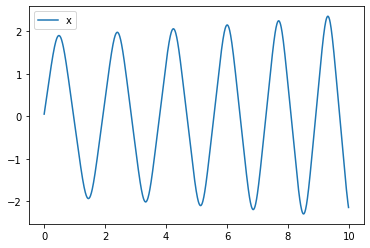

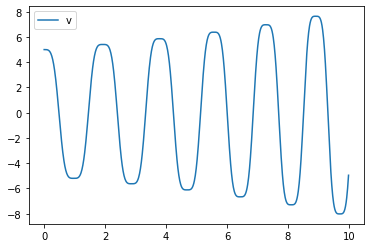

In [33]:
ts = dt*np.arange(nsteps)
plt.plot(ts,results['x'],label='x')
plt.legend()
plt.show()
plt.plot(ts,results['v'],label='v')
plt.legend()
plt.show()

It's oscillating back and forth, though not quite sinusoidal, since it's a steep potential at the edges.  Though it looks like the particle is moving a bit more each time, which doesn't sound quite right.  Let's look at the energies over time.

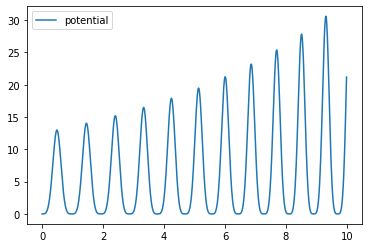

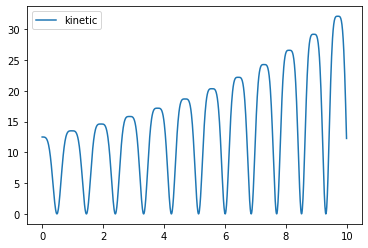

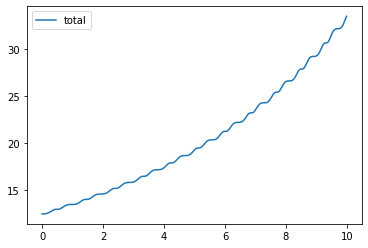

In [34]:
plt.plot(ts,results['PE'],label="potential")
plt.legend()
plt.show()
plt.plot(ts,results['KE'],label="kinetic")
plt.legend()
plt.show()
plt.plot(ts,results['Total_E'],label='total')
plt.legend()
plt.show()

That certainly does not look like energy conservation?   What could we do?

**Exploration**: See what happens to the trajectory and energy as you change:

1. Mass
2. Time step
3. Potential (if you want to!)


## Improved integration algorithms

Let's try another algorithm, called velocity Verlet (the Verlet series of methods was developed by French physicist Loup Verlet, in 1967 - this particular variation was developed by Bill Swope in 1992 (who I collaborated on with my first big paper as a graduate student!). 

In [35]:
def velocity_verlet(x,v,force,m=1,dt=1):

    '''
    a function that executes one step of numerical integration
    inputs:
        x (current position)
        v (current velocity)
        f (a function that computes the force)
        m = mass of particle
        dt = time interval        
    '''
    
    # half-step of velocity
    v_h = v + 0.5*dt*force(x)/m
    # full step of position
    x += v_h*dt
    # half-step of velocity
    v = v_h + 0.5*dt*force(x)/m
    return x,v

In this algorithm, I first calcuate the force at $x(t)$ to find the velocity at $v(t + \Delta/2)$, calculate the change in position with this *halfway* velocity, then call the force at the NEW position.  So the velocity used to calculate the new position comes half from the force at $t$, and half from the force at $t+\Delta t$.  

It makes sense that this might would work a bit better, because we are calculating the change in $x$ between $x(t)$ and $x(t+\Delta t)$ using the velocity halfway between them. 

In [36]:
def do_some_md_v2(nsteps=100, m=1, dt=0.1, 
               init_x = 0, init_v=6, algorithm='taylor'):

    '''
    inputs: 
        nsteps = number of steps to take
        m = mass of the particle
        dt = timestep
        init_x = initial value of x
        init_v = initial value of v
        algorithm: the algorithm to use (just one for now)
    '''

    xs = np.zeros(nsteps)
    vs = np.zeros(nsteps)
    
    PEs = np.zeros(nsteps)
    KEs = np.zeros(nsteps)
    Es = np.zeros(nsteps)

    x = init_x
    v = init_v

    for i in range(nsteps):
        if algorithm == 'taylor':
            xnew,vnew = taylor(x,v,force,m=m,dt=dt)
        elif algorithm == 'velocity_verlet':
            xnew, vnew = velocity_verlet(x,v,force,m=m,dt=dt)
        x = xnew
        v = vnew
        xs[i] = x
        vs[i] = v
        KEs[i] = 0.5*m*(vs[i]**2)
        PEs[i] = potential(x)
        Es[i] = PEs[i] + KEs[i]

    results = dict()
    results['x'] = xs
    results['v'] = vs
    results['KE'] = KEs
    results['PE'] = PEs
    results['Total_E'] = Es
    
    return results

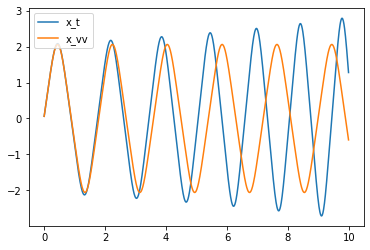

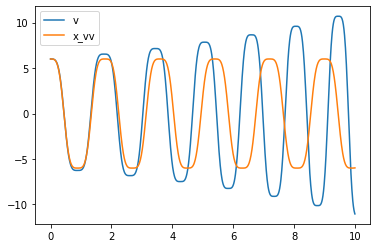

In [37]:
nsteps = 1000
dt = 0.01

results_t = do_some_md_v2(nsteps=nsteps,dt=dt,algorithm='taylor')
results_vv = do_some_md_v2(nsteps=nsteps,dt=dt,algorithm='velocity_verlet')

ts = dt*np.arange(nsteps)
plt.plot(ts,results_t['x'],label='x_t')
plt.plot(ts,results_vv['x'],label='x_vv')

plt.legend()
plt.show()
plt.plot(ts,results_t['v'],label='v')
plt.plot(ts,results_vv['v'],label='x_vv')
plt.legend()
plt.show()

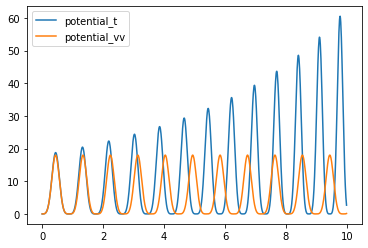

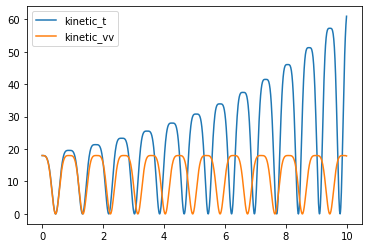

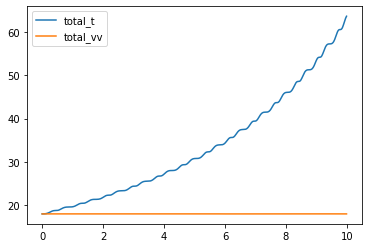

In [38]:
plt.plot(ts,results_t['PE'],label="potential_t")
plt.plot(ts,results_vv['PE'],label="potential_vv")
plt.legend()
plt.show()

plt.plot(ts,results_t['KE'],label="kinetic_t")
plt.plot(ts,results_vv['KE'],label="kinetic_vv")
plt.legend()
plt.show()

plt.plot(ts,results_t['Total_E'],label='total_t')
plt.plot(ts,results_vv['Total_E'],label='total_vv')
plt.legend()
plt.show()

**Exploration**: What happens when use velocity Verlet for longer timescales, or use larger timesteps?

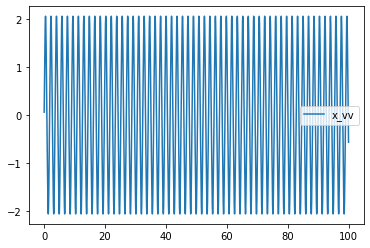

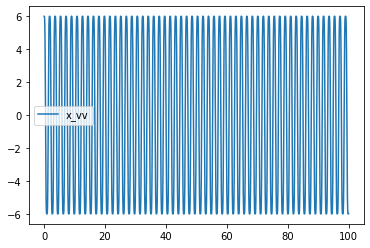

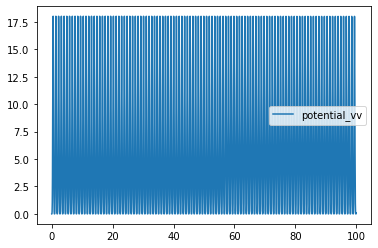

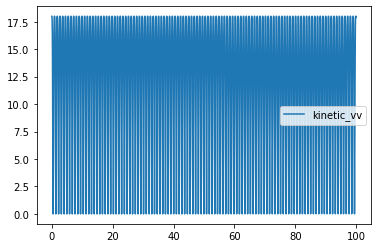

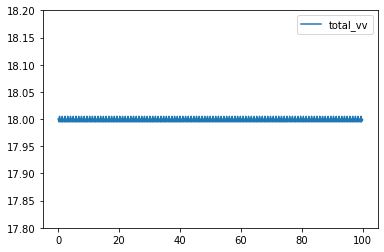

In [39]:
nsteps = 10000
dt = 0.01

results_vv = do_some_md_v2(nsteps=nsteps,dt=dt,algorithm='velocity_verlet')

ts = dt*np.arange(nsteps)
plt.plot(ts,results_vv['x'],label='x_vv')
plt.legend()
plt.show()

plt.plot(ts,results_vv['v'],label='x_vv')
plt.legend()
plt.show()

plt.plot(ts,results_vv['PE'],label="potential_vv")
plt.legend()
plt.show()

plt.plot(ts,results_vv['KE'],label="kinetic_vv")
plt.legend()
plt.show()

plt.plot(ts,results_vv['Total_E'],label='total_vv')
plt.legend()
plt.ylim(17.8,18.2)
plt.show()

This seems much better than our first test. Can we do even better?  
Let's try an algorithm that theoretically is accurate to higher order.  This one requires keeping track of the force at a previous step.

In [40]:
def beeman(x,v,force,oldx,m=1,dt=1):
    
    '''
    a function that executes one step of numerical integration
    inputs:
        x (current position)
        v (current velocity)
        f (a function that computes the force)
        oldx (the previous position)
        m = mass of particle
        dt = time interval        
    '''    
    
    amdt = force(oldx)/m  # force at t-dt
    at = force(x)/m # force at t
    x += v*dt + dt**2*(4*at-amdt)/6
    apdt = force(x)/m # force at t+dt
    v += dt*(5*apdt+8*at-amdt)/12
    return x,v

In [41]:
def do_some_md_v3(nsteps=100, m=1, dt=0.1, 
               init_x = 0, init_v=6, algorithm='taylor'):

    '''
    inputs: 
        nsteps = number of steps to take
        m = mass of the particle
        dt = timestep
        init_x = initial value of x
        init_v = initial value of v
        algorithm: the algorithm to use
    '''
    xs = np.zeros(nsteps)
    vs = np.zeros(nsteps)
    PEs = np.zeros(nsteps)
    KEs = np.zeros(nsteps)
    Es = np.zeros(nsteps)

    x = init_x
    v = init_v

    # for beeman
    # estimate oldx to order O(dt^3)
    oldx = x - dt*v-dt**2*force(x)/m
        
    for i in range(nsteps):
        if algorithm == 'taylor':
            xnew,vnew = taylor(x,v,force,m=m,dt=dt)
        elif algorithm == 'velocity_verlet':
            xnew, vnew = velocity_verlet(x,v,force,m=m,dt=dt)
        elif algorithm == 'beeman':
            xnew, vnew = beeman(x,v,force,oldx,m=m,dt=dt)
        else:
            print('No algorithm specified')    
        oldx = x
        x = xnew
        v = vnew
        xs[i] = x
        vs[i] = v
        KEs[i] = 0.5*m*(vs[i]**2)
        PEs[i] = potential(x)
        Es[i] = PEs[i] + KEs[i]

    results = dict()
    results['x'] = xs
    results['v'] = vs
    results['KE'] = KEs
    results['PE'] = PEs
    results['Total_E'] = Es
    
    return results

At low numbers of steps, it works very similarly. But at high numbers of steps, it starts to fail. . ., i.e. energy is not conserved.

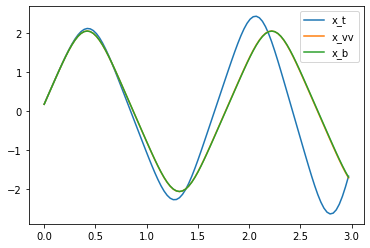

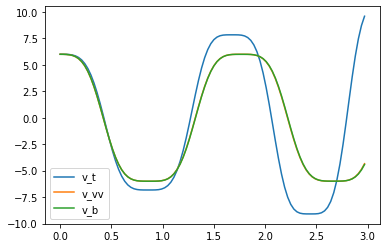

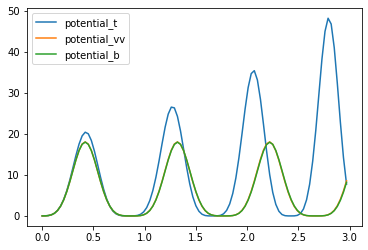

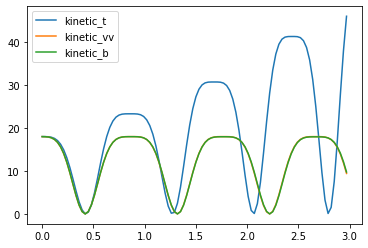

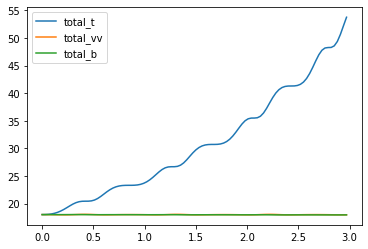

In [42]:
nsteps = 100
dt = 0.03

results_t = do_some_md_v3(nsteps=nsteps,dt=dt,algorithm='taylor')
results_vv = do_some_md_v3(nsteps=nsteps,dt=dt,algorithm='velocity_verlet')
results_b = do_some_md_v3(nsteps=nsteps,dt=dt,algorithm='beeman')

ts = dt*np.arange(nsteps)
plt.plot(ts,results_t['x'],label='x_t')
plt.plot(ts,results_vv['x'],label='x_vv')
plt.plot(ts,results_b['x'],label='x_b')

plt.legend()
plt.show()
plt.plot(ts,results_t['v'],label='v_t')
plt.plot(ts,results_vv['v'],label='v_vv')
plt.plot(ts,results_b['v'],label='v_b')
plt.legend()
plt.show()

plt.plot(ts,results_t['PE'],label="potential_t")
plt.plot(ts,results_vv['PE'],label="potential_vv")
plt.plot(ts,results_b['PE'],label="potential_b")
plt.legend()
plt.show()

plt.plot(ts,results_t['KE'],label="kinetic_t")
plt.plot(ts,results_vv['KE'],label="kinetic_vv")
plt.plot(ts,results_b['KE'],label="kinetic_b")
plt.legend()
plt.show()

plt.plot(ts,results_t['Total_E'],label='total_t')
plt.plot(ts,results_vv['Total_E'],label='total_vv')
plt.plot(ts,results_b['Total_E'],label='total_b')
plt.legend()
plt.show()


Although Beeman is good for short timescales (and for sufficiently short timescales, it can be shown to be more accurate than velocity verlet), for long timescales, it still drifts.

One reason is that the Verlet algorithm is what is called a *symplectic* algorithm.  We won't go into all the reasons of what symplectic means, though one key property of symplectic agorithms is that they conserve phase space, even if they have discrete timesteps, which is a property that the original Newton's equations of motion also have, and are are time-reversible, which Newton's equations also are. Beeman's algorithm is not symplectic, and does not conserve phase space, and is not time-reversible

Symplectic algorithms have something called a *shadow Hamilonian*. This means that these discrete algorithms exactly conserve a quantity that is close to, not not exactly, the true Hamiltonian.  the larger the timestep gets, the further this quantity gets from the shadow quantity.  The difference between the shadow Hamiltonian and the true Hamiltonian (if we have infinitely small time steps), $\tilde{H} - H$, is proportional to $\Delta t^2$ for the Verlet algorithms.

Verlet algorithms are thus really useful, and essentially all current MD programs use Verlet algorithms accurate to $\mathcal{O}(\Delta t^2)$, either velocity Verlet or some other version.

There are symplectic algorthims that are higher order, but they require more force evaluation per step.  But they do not scale well; if they require 2x as many force evaluations per step, you can take steps sizes that are less than 2x as long, so the total computational time per force evaluation is not as good.

We note that velocity Verlet still requires 2 calls per timestep.  Is there a way to get around this requirement? 

Hmm, the force we calculate at the END of the last step is the same as the first timestep.  Can we just do some bookkeeping, and smush those steps together? 

In [43]:
def leapfrog_verlet(x,v,force,m=1,dt=1):
    
    '''
    a function that executes one step of numerical integration
    inputs:
        x (current position)
        v (current velocity)
        f (a function that computes the force)
        m = mass of particle
        dt = time interval        
    '''    
        
    x += v*dt
    v += dt*force(x)/m
    
    return x,v

Then what we get at each iteration of the algorithm is the position at each timestep, and the velocity offset by 1/2 a timestep.  The velocities are leapfrogging the positions, rather than being in sync with them.

Let's try it!

In [44]:
def do_some_md_v4(nsteps=100, m=1, dt=0.1, 
               init_x = 0, init_v=6, algorithm='taylor'):

    '''
    a function that executes one step of numerical integration
    inputs:
        x (current position)
        v (current velocity)
        f (a function that computes the force)
        m = mass of particle
        dt = time interval        
    '''   
    
    xs = np.zeros(nsteps)
    vs = np.zeros(nsteps)
    PEs = np.zeros(nsteps)
    KEs = np.zeros(nsteps)
    Es = np.zeros(nsteps)

    x = init_x
    v = init_v

    # for beeman
    # estimate oldx to order O(dt^3)
    oldx = x - dt*v-dt**2*force(x)/m
        
    for i in range(nsteps):
        if algorithm == 'taylor':
            xnew,vnew = taylor(x,v,force,m=m,dt=dt)
        elif algorithm == 'velocity_verlet':
            xnew, vnew = velocity_verlet(x,v,force,m=m,dt=dt)
        elif algorithm == 'leapfrog_verlet':
            xnew, vnew = leapfrog_verlet(x,v,force,m=m,dt=dt)
        elif algorithm == 'beeman':
            xnew, vnew = beeman(x,v,force,oldx,m=m,dt=dt)
        else:
            print('No algorithm specified')    
        oldx = x
        x = xnew
        v = vnew
        xs[i] = x
        vs[i] = v
        KEs[i] = 0.5*m*(vs[i]**2)
        PEs[i] = potential(x)
        Es[i] = PEs[i] + KEs[i]

    results = dict()
    results['x'] = xs
    results['v'] = vs
    results['KE'] = KEs
    results['PE'] = PEs
    results['Total_E'] = Es
    
    return results

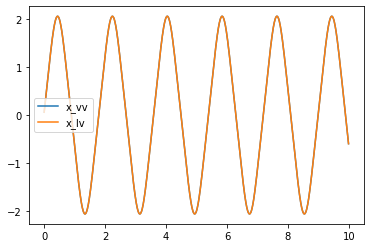

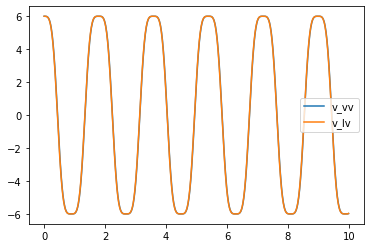

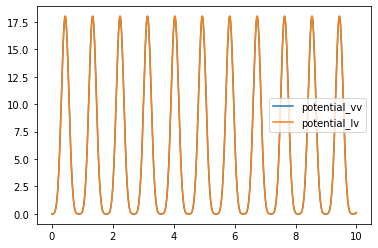

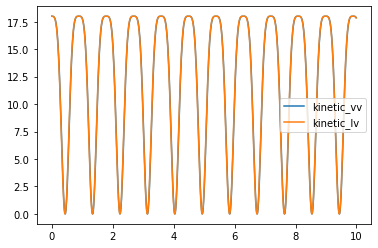

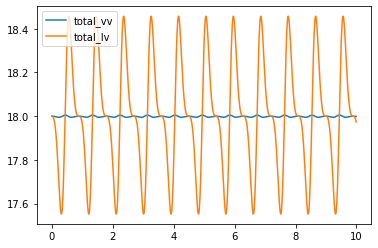

In [45]:
nsteps = 1000
dt = 0.01

results_vv = do_some_md_v4(nsteps=nsteps,dt=dt,algorithm='velocity_verlet')
results_lv = do_some_md_v4(nsteps=nsteps,dt=dt,algorithm='leapfrog_verlet')


ts = dt*np.arange(nsteps)
plt.plot(ts,results_vv['x'],label='x_vv')
plt.plot(ts,results_lv['x'],label='x_lv')

plt.legend()
plt.show()

plt.plot(ts,results_vv['v'],label='v_vv')
plt.plot(ts,results_lv['v'],label='v_lv')
plt.legend()
plt.show()

plt.plot(ts,results_vv['PE'],label="potential_vv")
plt.plot(ts,results_lv['PE'],label="potential_lv")
plt.legend()
plt.show()

plt.plot(ts,results_vv['KE'],label="kinetic_vv")
plt.plot(ts,results_lv['KE'],label="kinetic_lv")
plt.legend()
plt.show()

plt.plot(ts,results_vv['Total_E'],label='total_vv')
plt.plot(ts,results_lv['Total_E'],label='total_lv')
plt.legend()
plt.show()

Now, the trajectory looks similar, but the conserved energy is off a little.  Why? 

**Question**: What properties am I calculating wrong? 

**Answer**: We are trying to compute the energy with the potential from the full steps, and the kinetic energy from the half steps, in between. Let's do the bookkeeping so that we get the same kinetic energy as before, by calculating the average of the kinetic energies before and after (in the case of velocity verlet)

In [68]:
def do_some_md_v5(nsteps=100, m=1, dt=0.1, 
               init_x = 0, init_v=6, algorithm='taylor'):

    xs = np.zeros(nsteps)
    vs = np.zeros(nsteps)
    PEs = np.zeros(nsteps)
    KEs = np.zeros(nsteps)
    Es = np.zeros(nsteps)

    x = init_x
    v = init_v

    # for beeman
    # estimate oldx to order O(dt^3)
    oldx = x - dt*v-dt**2*force(x)/m
        
    for i in range(nsteps):
        if algorithm == 'taylor':
            xnew,vnew = taylor(x,v,force,m=m,dt=dt)
        elif algorithm == 'velocity_verlet':
            xnew, vnew = velocity_verlet(x,v,force,m=m,dt=dt)
        elif algorithm == 'leapfrog_verlet':
            vold = v  ### KEEP THIS!
            xnew, vnew = leapfrog_verlet(x,v,force,m=m,dt=dt)
        elif algorithm == 'beeman':
            xnew, vnew = beeman(x,v,force,oldx,m=m,dt=dt)
        else:
            print('No algorithm specified')    
        oldx = x
        x = xnew
        v = vnew
        xs[i] = x
        vs[i] = v
        if algorithm == 'leapfrog_verlet':
            KEs[i] = 0.5*m*(0.5*(vs[i]+vold))**2  # Need to average!
        else:
            KEs[i] = 0.5*m*(vs[i]**2)
        PEs[i] = potential(x)
        Es[i] = PEs[i] + KEs[i]

    results = dict()
    results['x'] = xs
    results['v'] = vs
    results['KE'] = KEs
    results['PE'] = PEs
    results['Total_E'] = Es
    
    return results

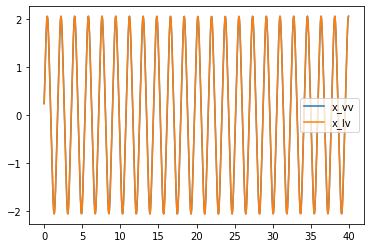

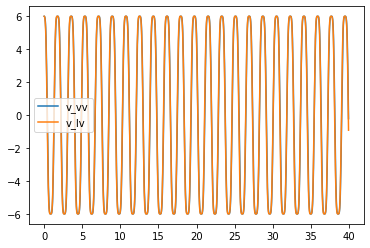

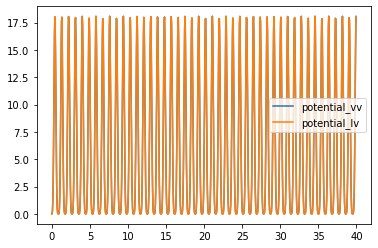

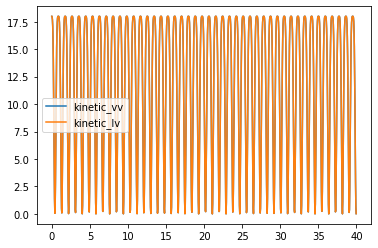

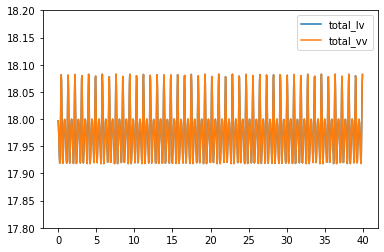

In [47]:
nsteps = 1000
dt = 0.04

results_vv = do_some_md_v5(nsteps=nsteps,dt=dt,algorithm='velocity_verlet')
results_lv = do_some_md_v5(nsteps=nsteps,dt=dt,algorithm='leapfrog_verlet')


ts = dt*np.arange(nsteps)
plt.plot(ts,results_vv['x'],label='x_vv')
plt.plot(ts,results_lv['x'],label='x_lv')

plt.legend()
plt.show()

plt.plot(ts,results_vv['v'],label='v_vv')
plt.plot(ts,results_lv['v'],label='v_lv')
plt.legend()
plt.show()

plt.plot(ts,results_vv['PE'],label="potential_vv")
plt.plot(ts,results_lv['PE'],label="potential_lv")
plt.legend()
plt.show()

plt.plot(ts,results_vv['KE'],label="kinetic_vv")
plt.plot(ts,results_lv['KE'],label="kinetic_lv")
plt.legend()
plt.show()

plt.plot(ts,results_lv['Total_E'],label='total_lv')
plt.plot(ts,results_vv['Total_E'],label='total_vv')
plt.ylim([17.8,18.2])
plt.legend()
plt.show()

Now let's try a more complicated potential:

In [57]:
# double well potential
def potential(x):
    pot = x**4 - 8*x**3 + 15*x**2
    return pot

def force(x):
    f = -(4*x**3 - 24*x**2 + 30*x)
    return f

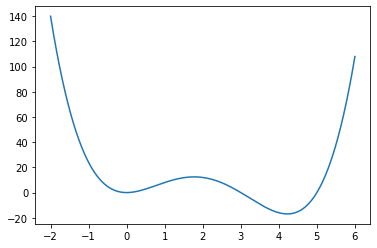

In [58]:
xlist = np.linspace(-2,6,1000)
plt.plot(xlist,potential(xlist))
plt.show()

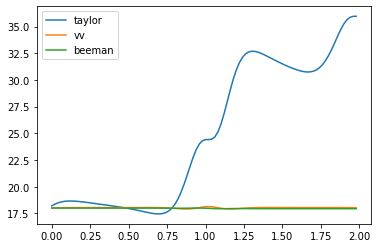

In [60]:
nsteps = 100
dt = 0.02
results_taylor = do_some_md_v5(nsteps=nsteps,dt=dt,algorithm='taylor')
results_vv = do_some_md_v5(nsteps=nsteps,dt=dt,algorithm='velocity_verlet')
results_beeman = do_some_md_v5(nsteps=nsteps,dt=dt,algorithm='beeman')

ts = dt*np.arange(nsteps)
plt.plot(ts,results_taylor['Total_E'],label='taylor')
plt.plot(ts,results_vv['Total_E'],label='vv')
plt.plot(ts,results_beeman['Total_E'],label='beeman')
plt.legend()
plt.show()

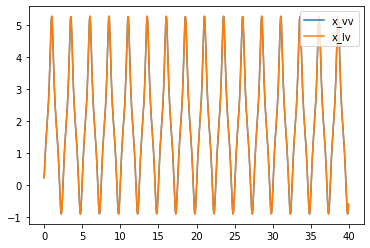

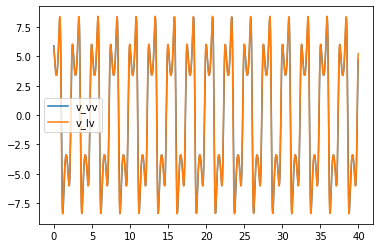

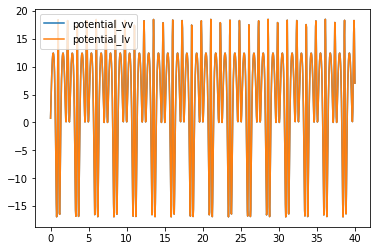

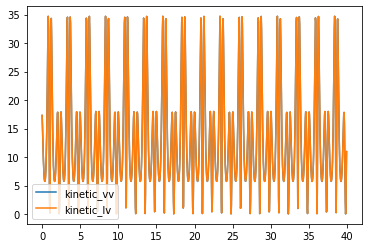

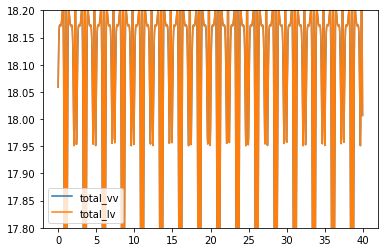

In [61]:
nsteps = 1000
dt = 0.04

results_vv = do_some_md_v5(nsteps=nsteps,dt=dt,algorithm='velocity_verlet')
results_lv = do_some_md_v5(nsteps=nsteps,dt=dt,algorithm='leapfrog_verlet')


ts = dt*np.arange(nsteps)
plt.plot(ts,results_vv['x'],label='x_vv')
plt.plot(ts,results_lv['x'],label='x_lv')

plt.legend()
plt.show()

plt.plot(ts,results_vv['v'],label='v_vv')
plt.plot(ts,results_lv['v'],label='v_lv')
plt.legend()
plt.show()

plt.plot(ts,results_vv['PE'],label="potential_vv")
plt.plot(ts,results_lv['PE'],label="potential_lv")
plt.legend()
plt.show()

plt.plot(ts,results_vv['KE'],label="kinetic_vv")
plt.plot(ts,results_lv['KE'],label="kinetic_lv")
plt.legend()
plt.show()

plt.plot(ts,results_vv['Total_E'],label='total_vv')
plt.plot(ts,results_lv['Total_E'],label='total_lv')
plt.ylim([17.8,18.2])
plt.legend()
plt.show()

**Question**: We have seen that the fluctuations around average change get smaller as the timestep decreases.  How does the RMSD of the total energy scale with timestep, given a fixed total simulation time?

**Answer**:

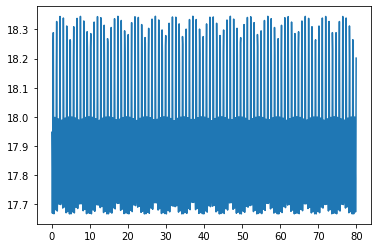

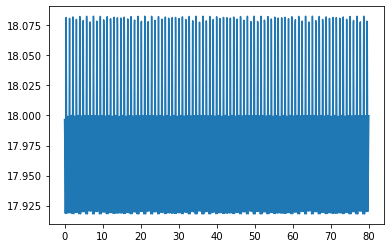

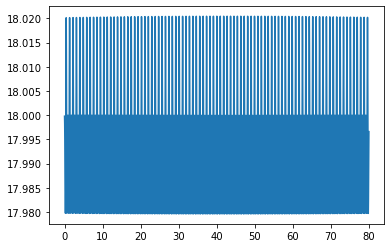

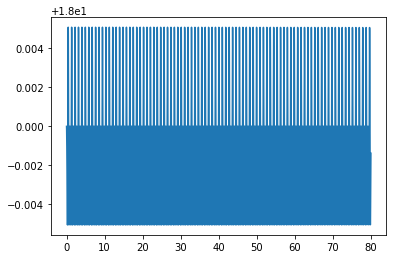

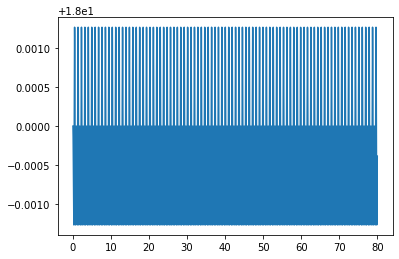

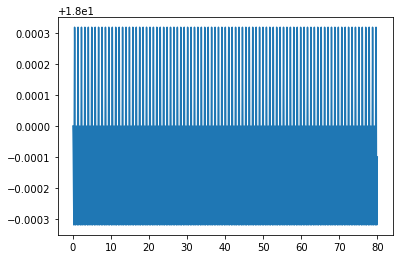

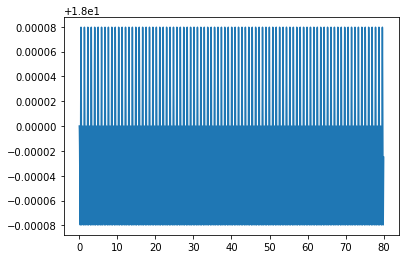

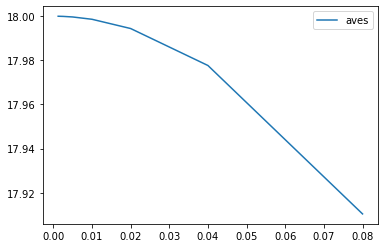

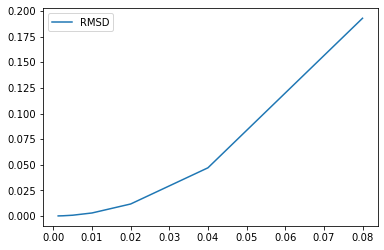

4.1059325889328955
4.023255387369531
4.005621882802672
4.001389030284812
4.000343506001597
4.000084123606878


In [56]:
nsteps = [1000,2000,4000,8000,16000,32000,64000]
dts    = [ 0.08 ,0.04,0.02,0.01,0.005,0.0025,0.00125]

RMSDs = list()
aves = list()
for n,dt in zip(nsteps,dts):
    results = do_some_md_v5(nsteps=n,dt=dt,algorithm='velocity_verlet')
    ave = np.mean(results['Total_E'])
    RMSDs.append(np.sqrt(np.mean((results['Total_E']-ave)**2)))
    aves.append(ave)
    ts = dt*np.arange(n)
    plt.plot(ts,results['Total_E'], label='total E ave')
    plt.show()

plt.plot(dts, aves, label='aves')
plt.legend()
plt.show()

plt.plot(dts, RMSDs, label='RMSD')
plt.legend()
plt.show()

for i in range(len(dts)-1):
    print(RMSDs[i]/RMSDs[i+1])


**Answer**: Each time the timestep halves, the RMSD goes down by a factor of 4, so the RMSD $\propto \Delta t^2$

**Question**: What happens as the timestep gets too big? How big does it get before it starts to drift?  Try it with the quadratic potential.

MD works OK with dt= 0.18


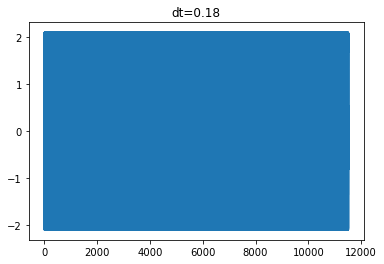

MD works OK with dt= 0.19


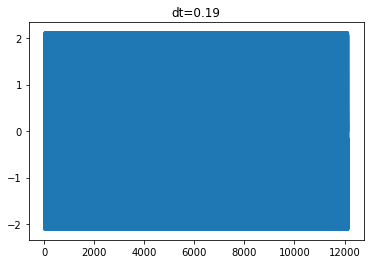

MD works OK with dt= 0.2


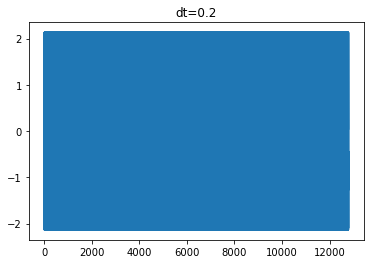

MD works OK with dt= 0.205


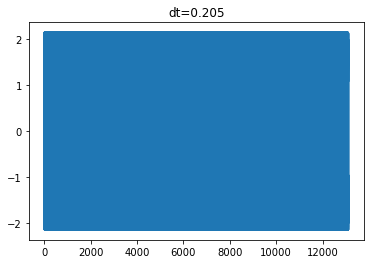

MD works OK with dt= 0.208


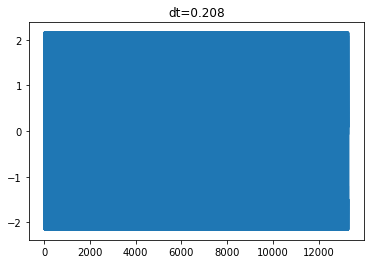

MD works OK with dt= 0.209


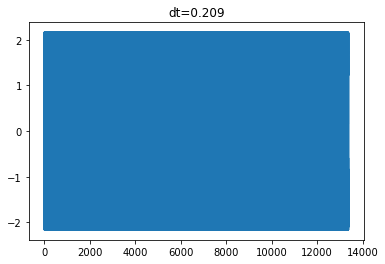

OverflowError: (34, 'Result too large')

In [74]:
nsteps = 100
dts    = [0.18,0.19,0.20,0.205,0.208,0.209,0.210]
RMSDs = list()
aves = list()
for dt in dts:
    ts = dt*np.arange(n)
    results = do_some_md_v5(nsteps=n,dt=dt,algorithm='velocity_verlet')
    print("MD works OK with dt=",dt)
    plt.title(f'dt={dt}')
    plt.plot(ts,results['x'], label='x')
    plt.show()


It basically behaves just fine, until it suddently explodes!  

### Stiffness in integrators

Let's try the problem with a higher power, steeper, potential. What happens when you run with increasingly longer timesteps?

In [75]:
def potential(x):
    pot = x**16
    return pot

def force(x):
    f = -16*x**15  # -d/dx(U)
    return f

MD works OK with dt= 0.023


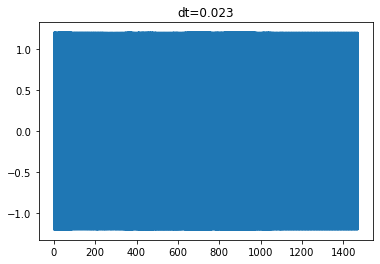

MD works OK with dt= 0.02305


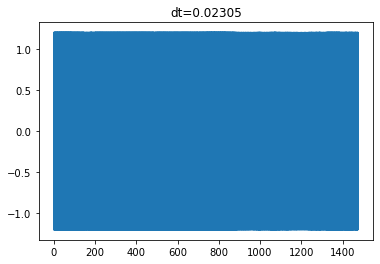

OverflowError: (34, 'Result too large')

In [88]:
nnsteps = 100
dts    = [0.023,0.02305,0.0231]
RMSDs = list()
aves = list()
for dt in dts:
    ts = dt*np.arange(n)
    results = do_some_md_v5(nsteps=n,dt=dt,algorithm='velocity_verlet')
    print("MD works OK with dt=",dt)
    plt.title(f'dt={dt}')
    plt.plot(ts,results['x'], label='x')
    plt.show()


Note that as the potential changes more abruptly, we need to take a shorter and shorter steps.  The steepnees of the potential in some parts of the configuration space is called *stiffness*. The stiffer the differential equations (larger the derivatives $dU/dx$ are), the shorter the timesteps you are able to take before the simulation falls apart.